In [1]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /scratch/gpfs/KANG/hirak/mambaforge/envs/r43/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.35   IRdisplay_1.1   utf8_1.2.4      base64enc_0.1-3
 [5] fastmap_1.1.1   glue_1.7.0      htmltools_0.5.7 repr_1.1.6     
 [9] lifecycle_1.0.4 cli_3.6.2       

In [2]:
suppressPackageStartupMessages({
  library(Seurat)
  library(dplyr)
  library(ggplot2)
  library(scCustomize)
  library(scater)
    library(RColorBrewer)
    library(data.table)
    library(stringr)
library(tibble)
    library(tidyr)
    library(scDblFinder)
    library(scCustomize)
    library(cowplot)
library(patchwork)
})

In [3]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [4]:
organoid = readRDS('seurat_objects/organoid.rds')

In [5]:
new_annot <- c(
  "G1 phase Sympathoblasts",
  "S phase Sympathoblasts",
  "G2-M phase Sympathoblasts",
  "C1",
  "Chromaffin",
  "G1-S phase Sympathoblasts",
  "C2",
  "B cells",
  "C3",
  "T cells",
  "M phase Sympathoblasts",
  "Myeloid",
  "C4",
  "Mesenchymal"
)

In [7]:
organoid@meta.data$new.annot=new_annot[as.numeric(organoid@meta.data$seurat_clusters)]

## Figure 4C

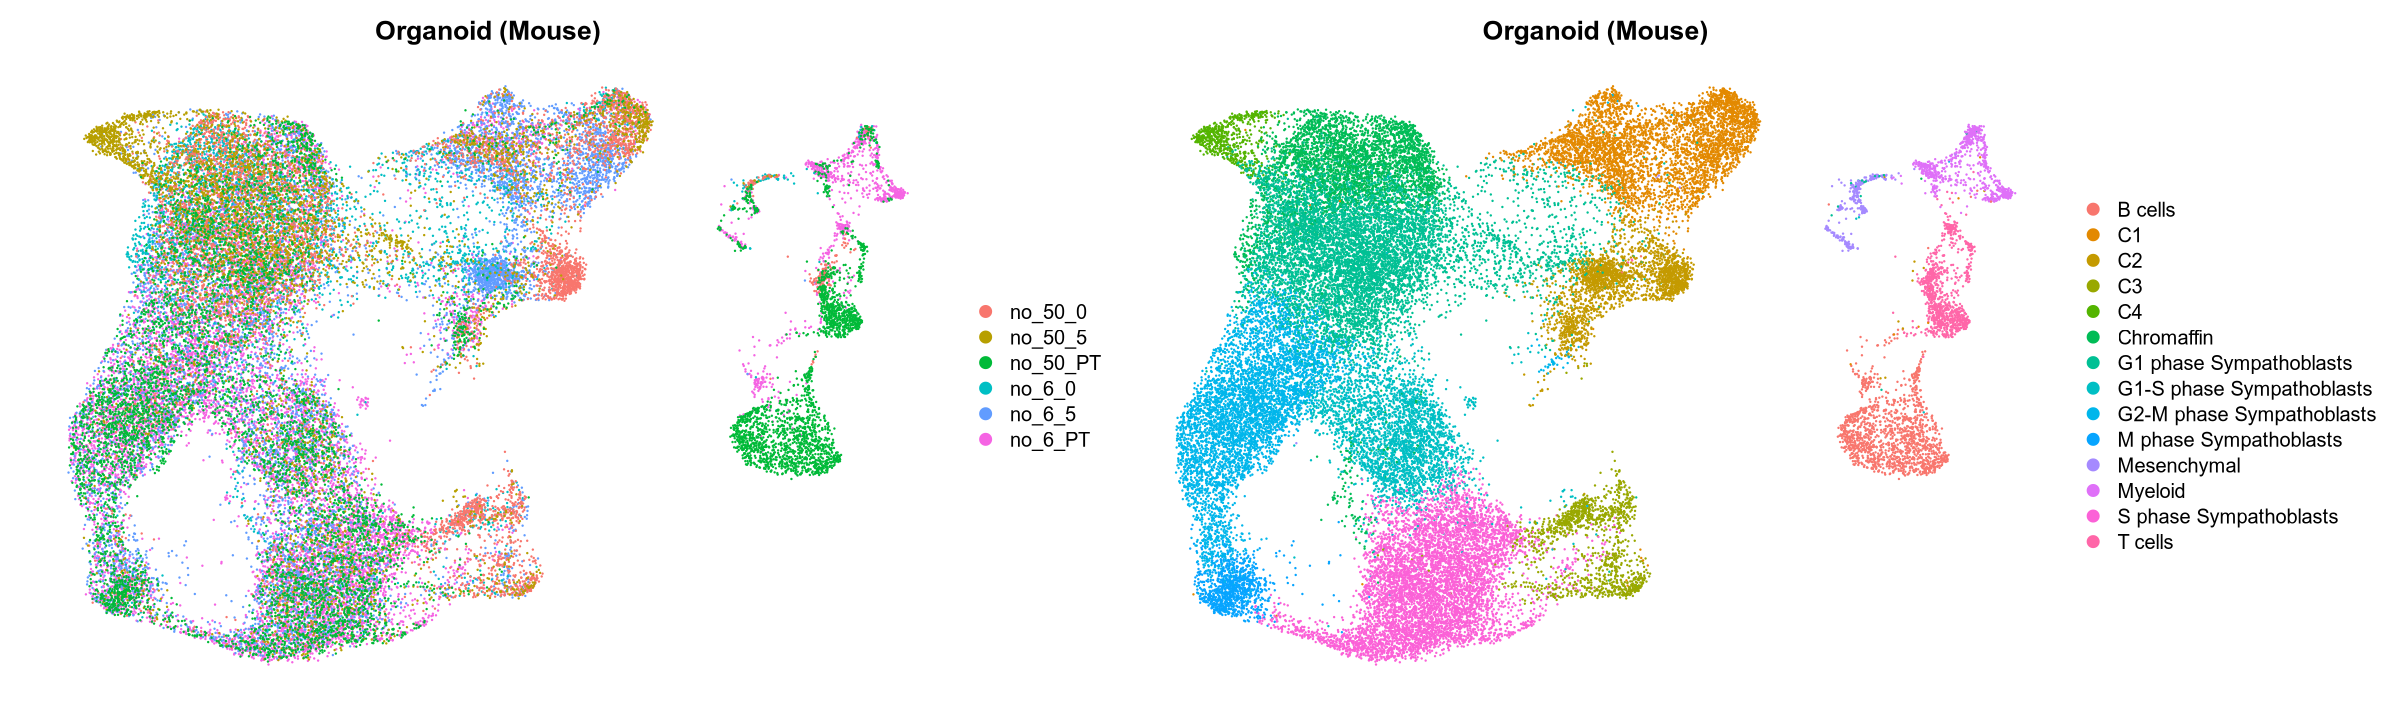

In [8]:
fig.size(6,20)
p1 = DimPlot(organoid, label = F, repel = T, reduction = "umap",
               group.by = "orig.ident")+labs(title="Organoid (Mouse)") + NoAxes()
p2 = DimPlot(organoid, label = F, repel = T, reduction = "umap",
               group.by = "new.annot")+labs(title="Organoid (Mouse)") + NoAxes()
p1 | p2

## Figure 4D

In [11]:
cell_type_order <- list(
  "Chromaffin",
  "G1 phase Sympathoblasts",
  "G1-S phase Sympathoblasts",
  "S phase Sympathoblasts",
  "G2-M phase Sympathoblasts",
  "M phase Sympathoblasts",
  "C1",
  "C2",
  "C3",
  "C4",
  "Mesenchymal",
  "Myeloid",
  "T cells",
  "B cells"
)


In [13]:
Idents(organoid) = "new.annot"

In [14]:
organoid@active.ident = factor(organoid@active.ident, levels = cell_type_order )

In [16]:
annot.2 = openxlsx::read.xlsx(
    "spread_sheets/organoid_dotplot.xlsx",
    sheet = 'Long_Dotplot'
)

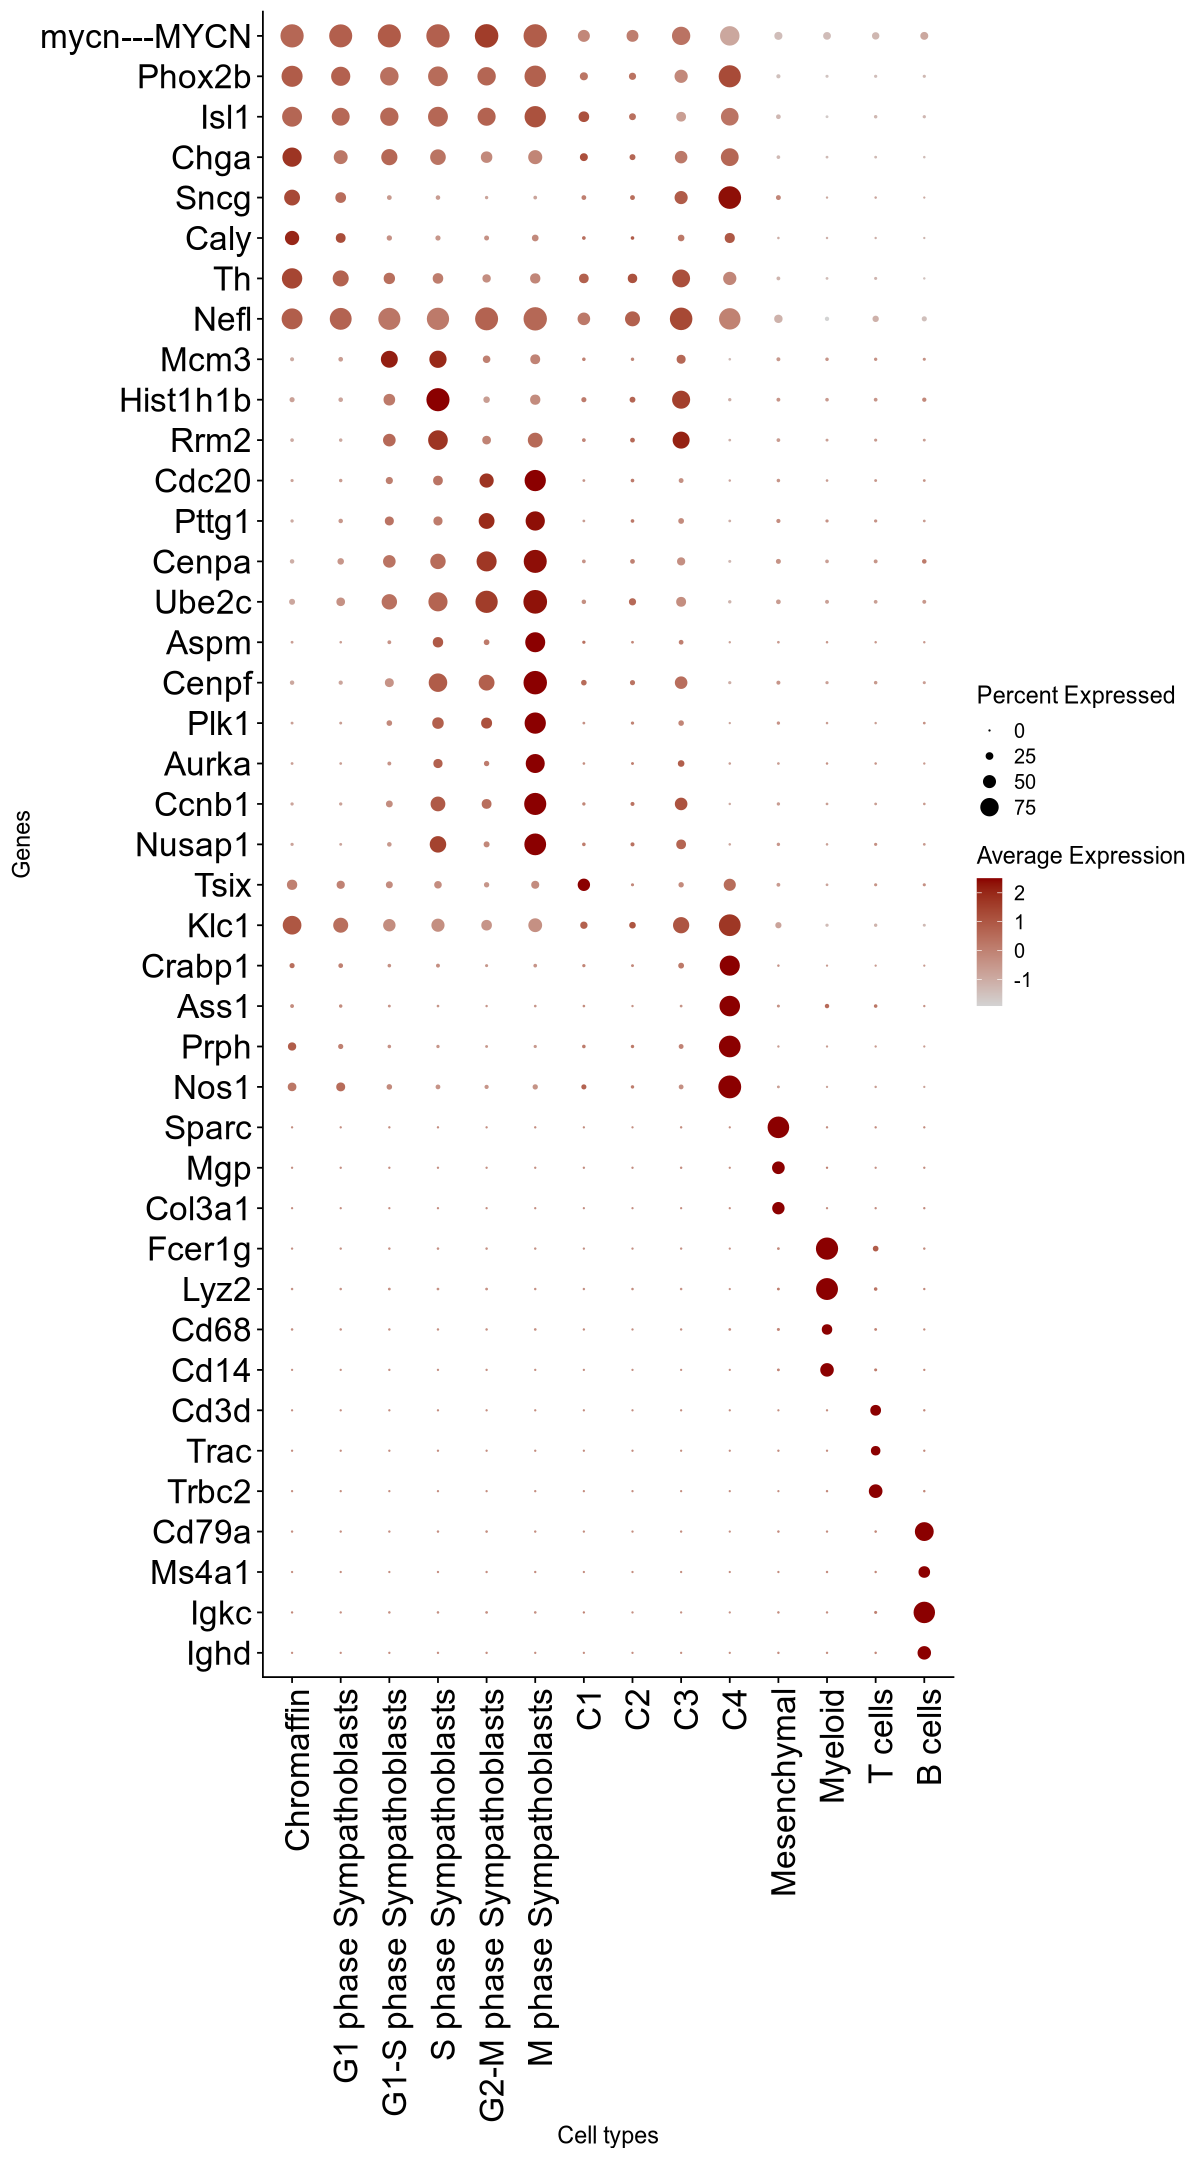

In [17]:
fig.size(18,10)
pdot = DotPlot(
        organoid, 
        assay='RNA',
        features = unique(annot.2$Gene) %>% rev,  
        cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(
        axis.text.x = element_text(size=20,angle = 90, hjust = 1,vjust = 0.7),
        axis.text.y = element_text(size=20)
       ) +
        xlab('Genes')+
        ylab('Cell types')
pdot

## Figure 4E

In [18]:
cc.genes.mm = readRDS('spread_sheets/cc.genes.mm.rds')
s.genes = cc.genes.mm$s.genes
g2m.genes = cc.genes.mm$g2m.genes

In [19]:
organoid <- CellCycleScoring(organoid, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

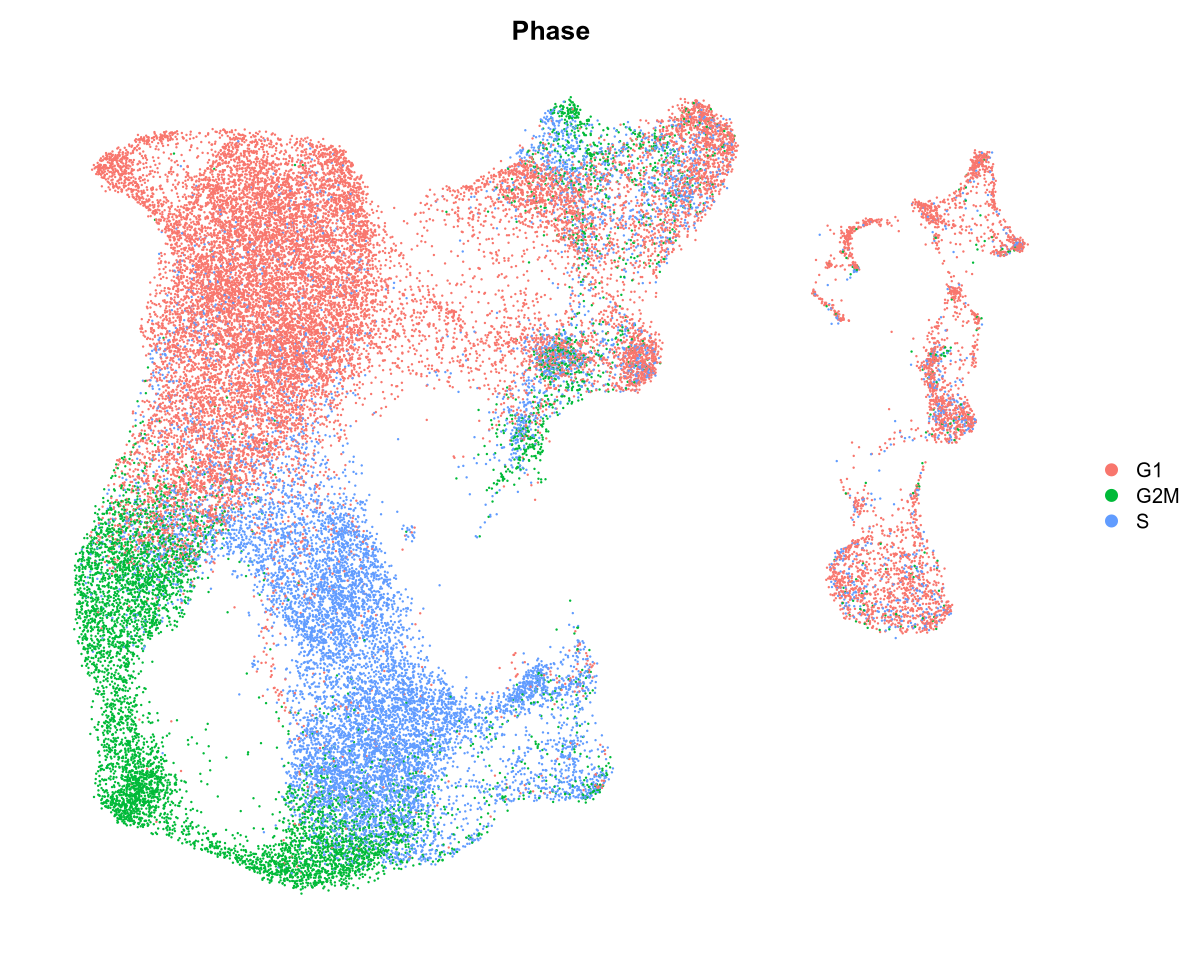

In [20]:
fig.size(8,10)
p1 = DimPlot(organoid, group.by = "Phase") + NoAxes()
p1

In [23]:
getwd()

[1] "/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/notebook/With_Ribosom/Cancer_Research_Revision_Notebooks/github_notebooks"

## Figure 5D

In [25]:
signature.df = openxlsx::read.xlsx(
    'spread_sheets/organoid_survival_signature.xlsx'
)

In [27]:
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Human.Gene), .groups = 'drop')
sig_groups_list = sig_groups$ValueList
names(sig_groups_list) = sig_groups$Annotation

In [34]:
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Mouse.Gene), .groups = 'drop')
sig_groups_list.mouse = sig_groups$ValueList
names(sig_groups_list.mouse) = sig_groups$Annotation

In [29]:
organoid@meta.data[organoid@meta.data %>% filter(grepl("PT", orig.ident)) %>% rownames,
                        'species_organoid' ] = 'In vivo'

In [30]:
organoid@meta.data[organoid@meta.data %>% filter(!grepl("PT", orig.ident)) %>% rownames,
                        'species_organoid' ] = 'Ex vivo'

In [31]:
DefaultAssay(organoid) = "RNA"

In [35]:
fig.size(16, 12)
plot.list = list()
for (label in sig_groups_list.mouse %>% names){
plot.list[[label]] = FeaturePlot_scCustom(
    organoid, 
    reduction = "umap", 
    features = sig_groups_list.mouse[[label]],
    split.by = 'species_organoid') + ggtitle(label)
}


NOTE: FeaturePlot_scCustom uses a specified `na_cutoff` when plotting to
color cells with no expression as background color separate from color scale.
Please ensure `na_cutoff` value is appropriate for feature being plotted.
Default setting is appropriate for use when plotting from 'RNA' assay.
When `na_cutoff` not appropriate (e.g., module scores) set to NULL to
plot all cells in gradient color palette.

-----This message will be shown once per session.-----
Warning message:
“All cells have the same value (0) of “Hmx3””


In [37]:
sig_groups_list.mouse %>% names

[1] "Neurite outgrowth"        "Neuronal Differentiation"
[3] "S phase Sympathoblasts"   "Synaptic signaling"

Clusters
--------------------
C2 -- Neurite outgrowth

C4 -- Neuronal Differentiation

C3 -- S phase Sympathoblasts

C1 -- Synaptic signaling

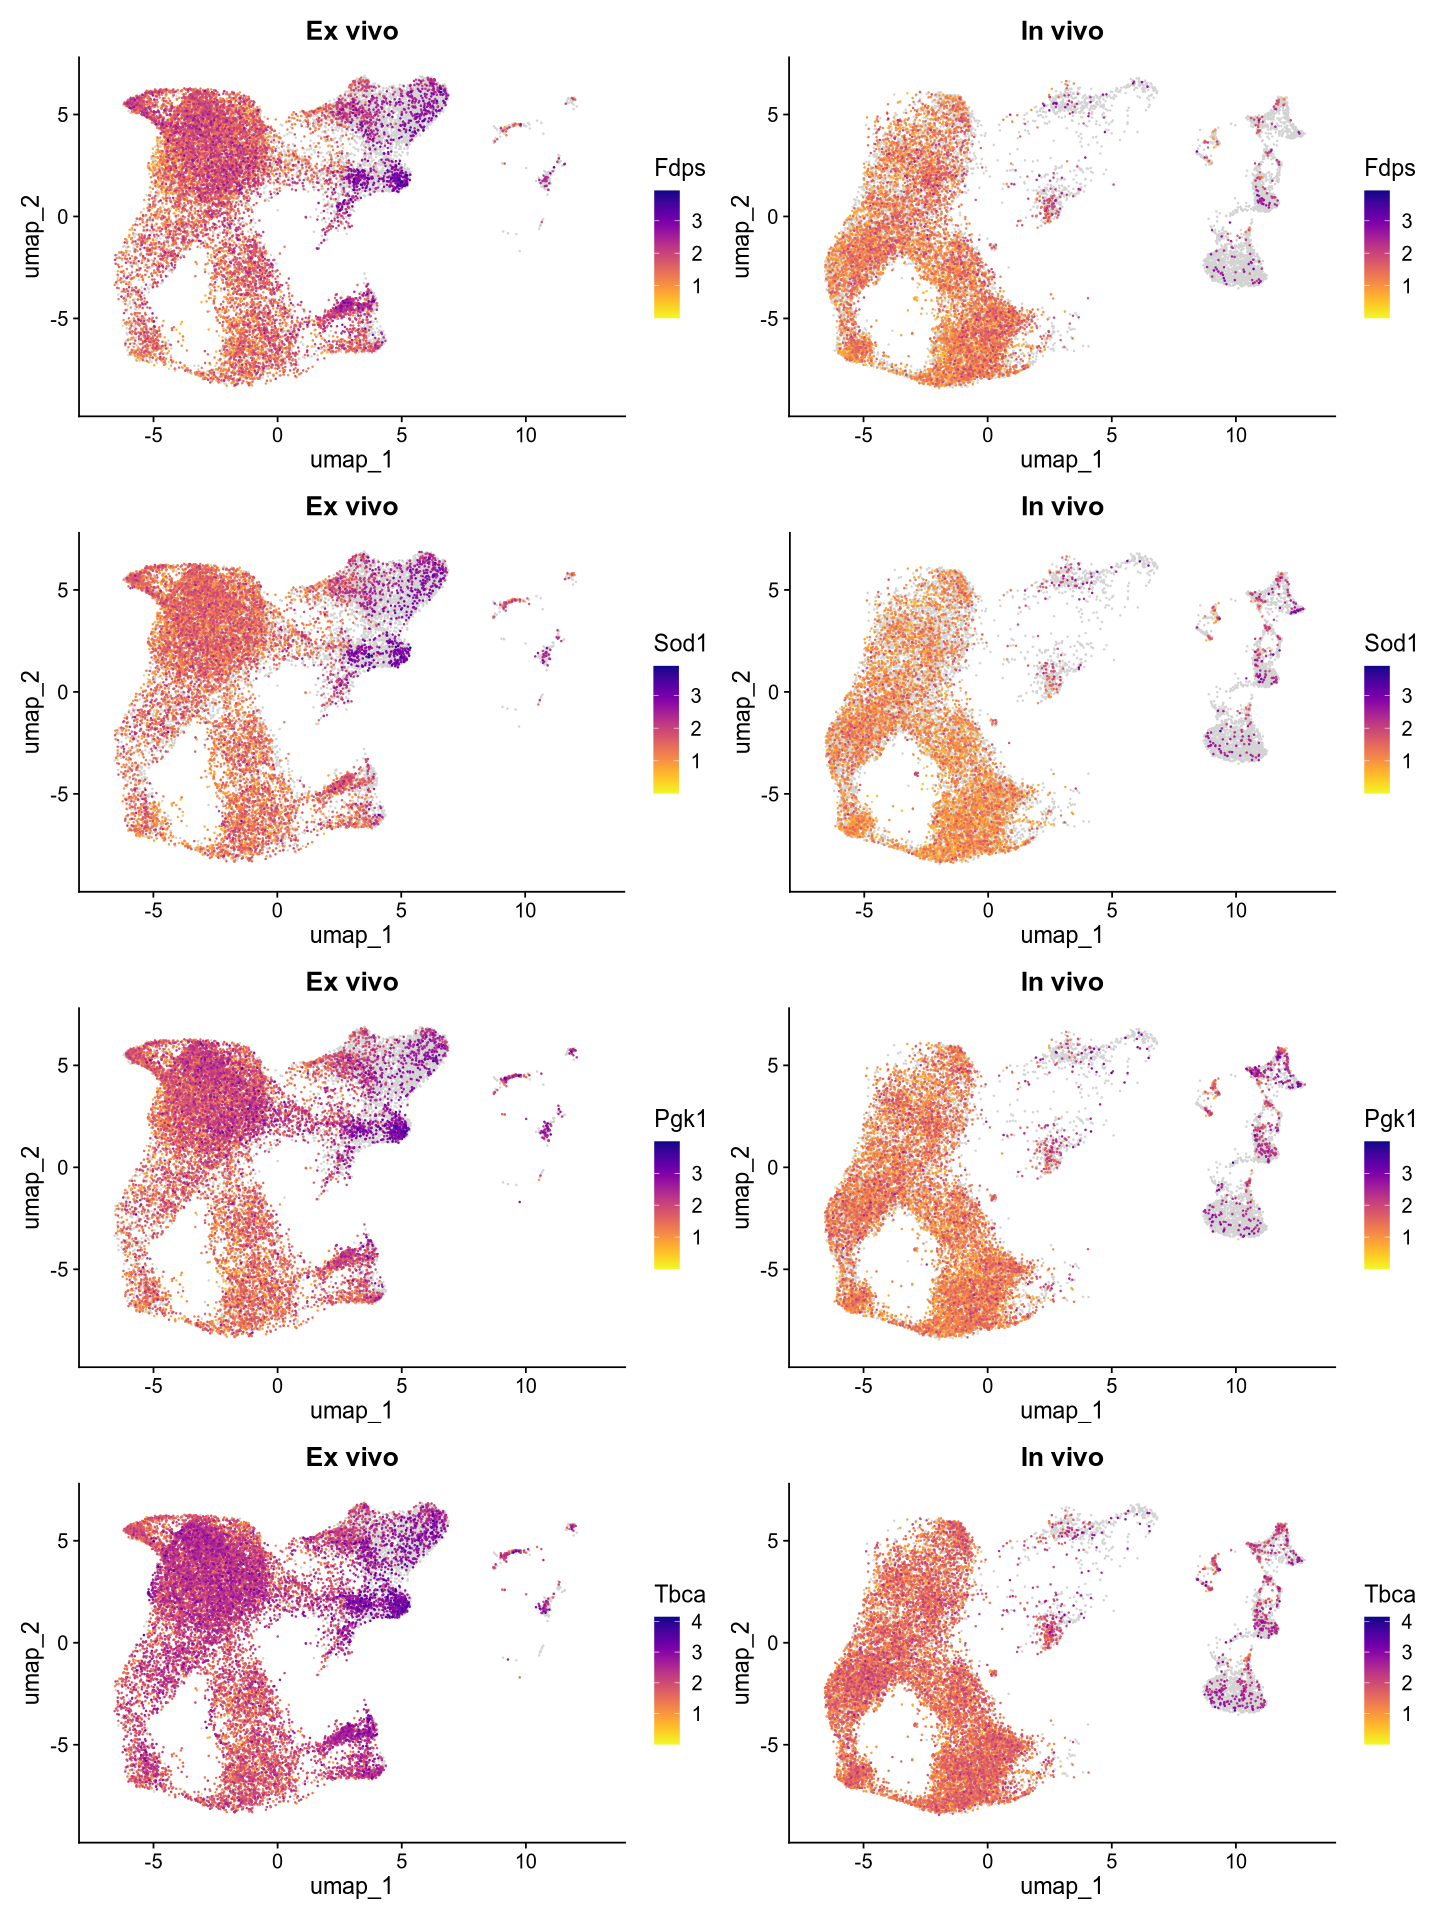

In [38]:
fig.size(16, 12)
plot.list[['Neurite outgrowth']]

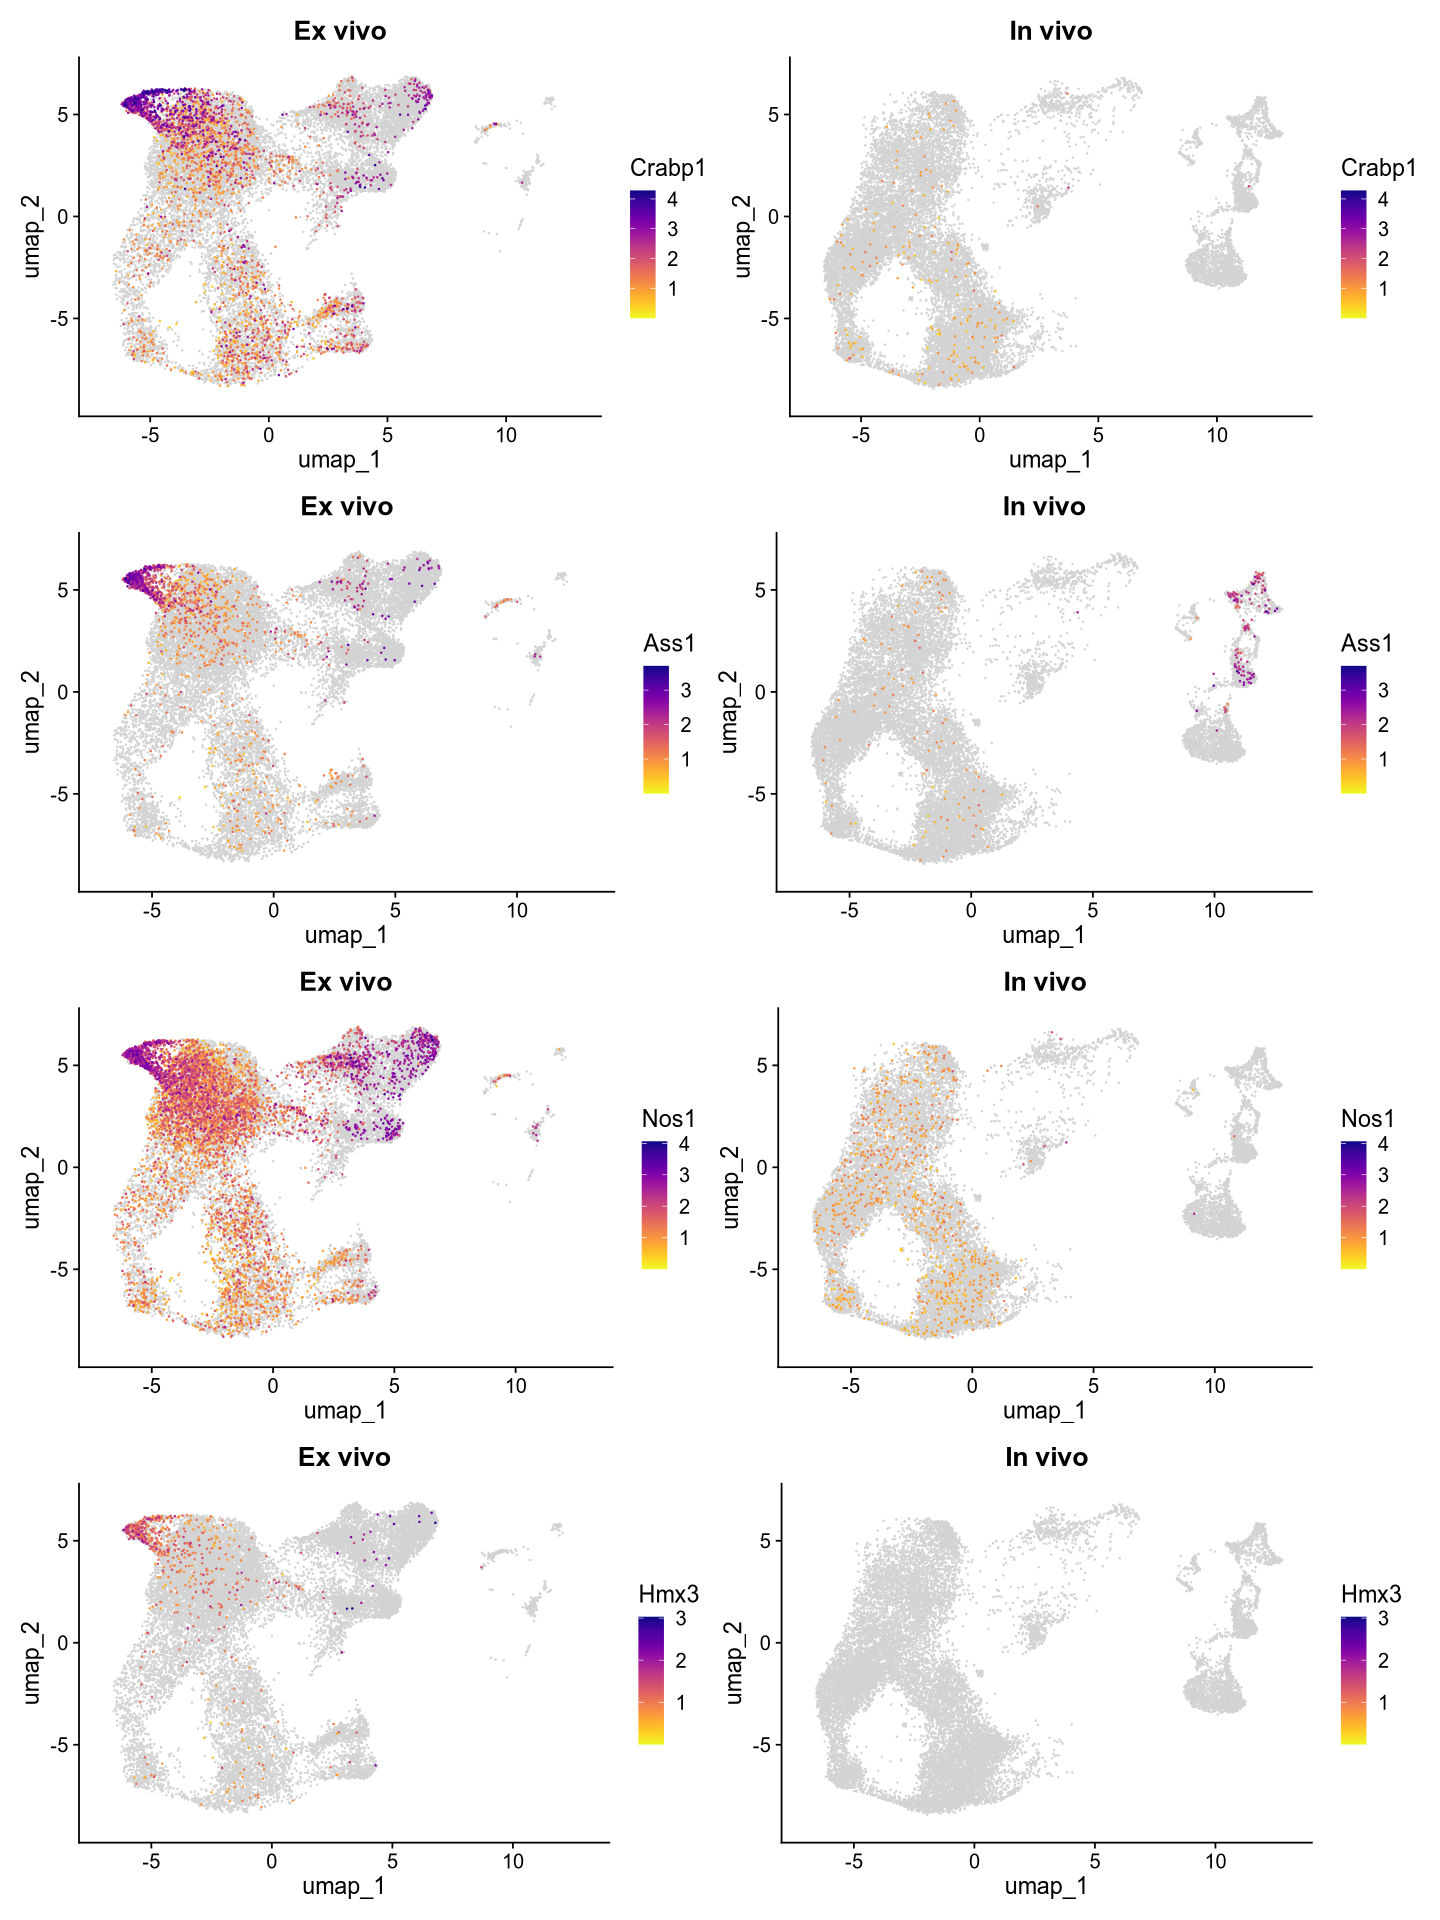

In [39]:
fig.size(16, 12)
plot.list[['Neuronal Differentiation']]

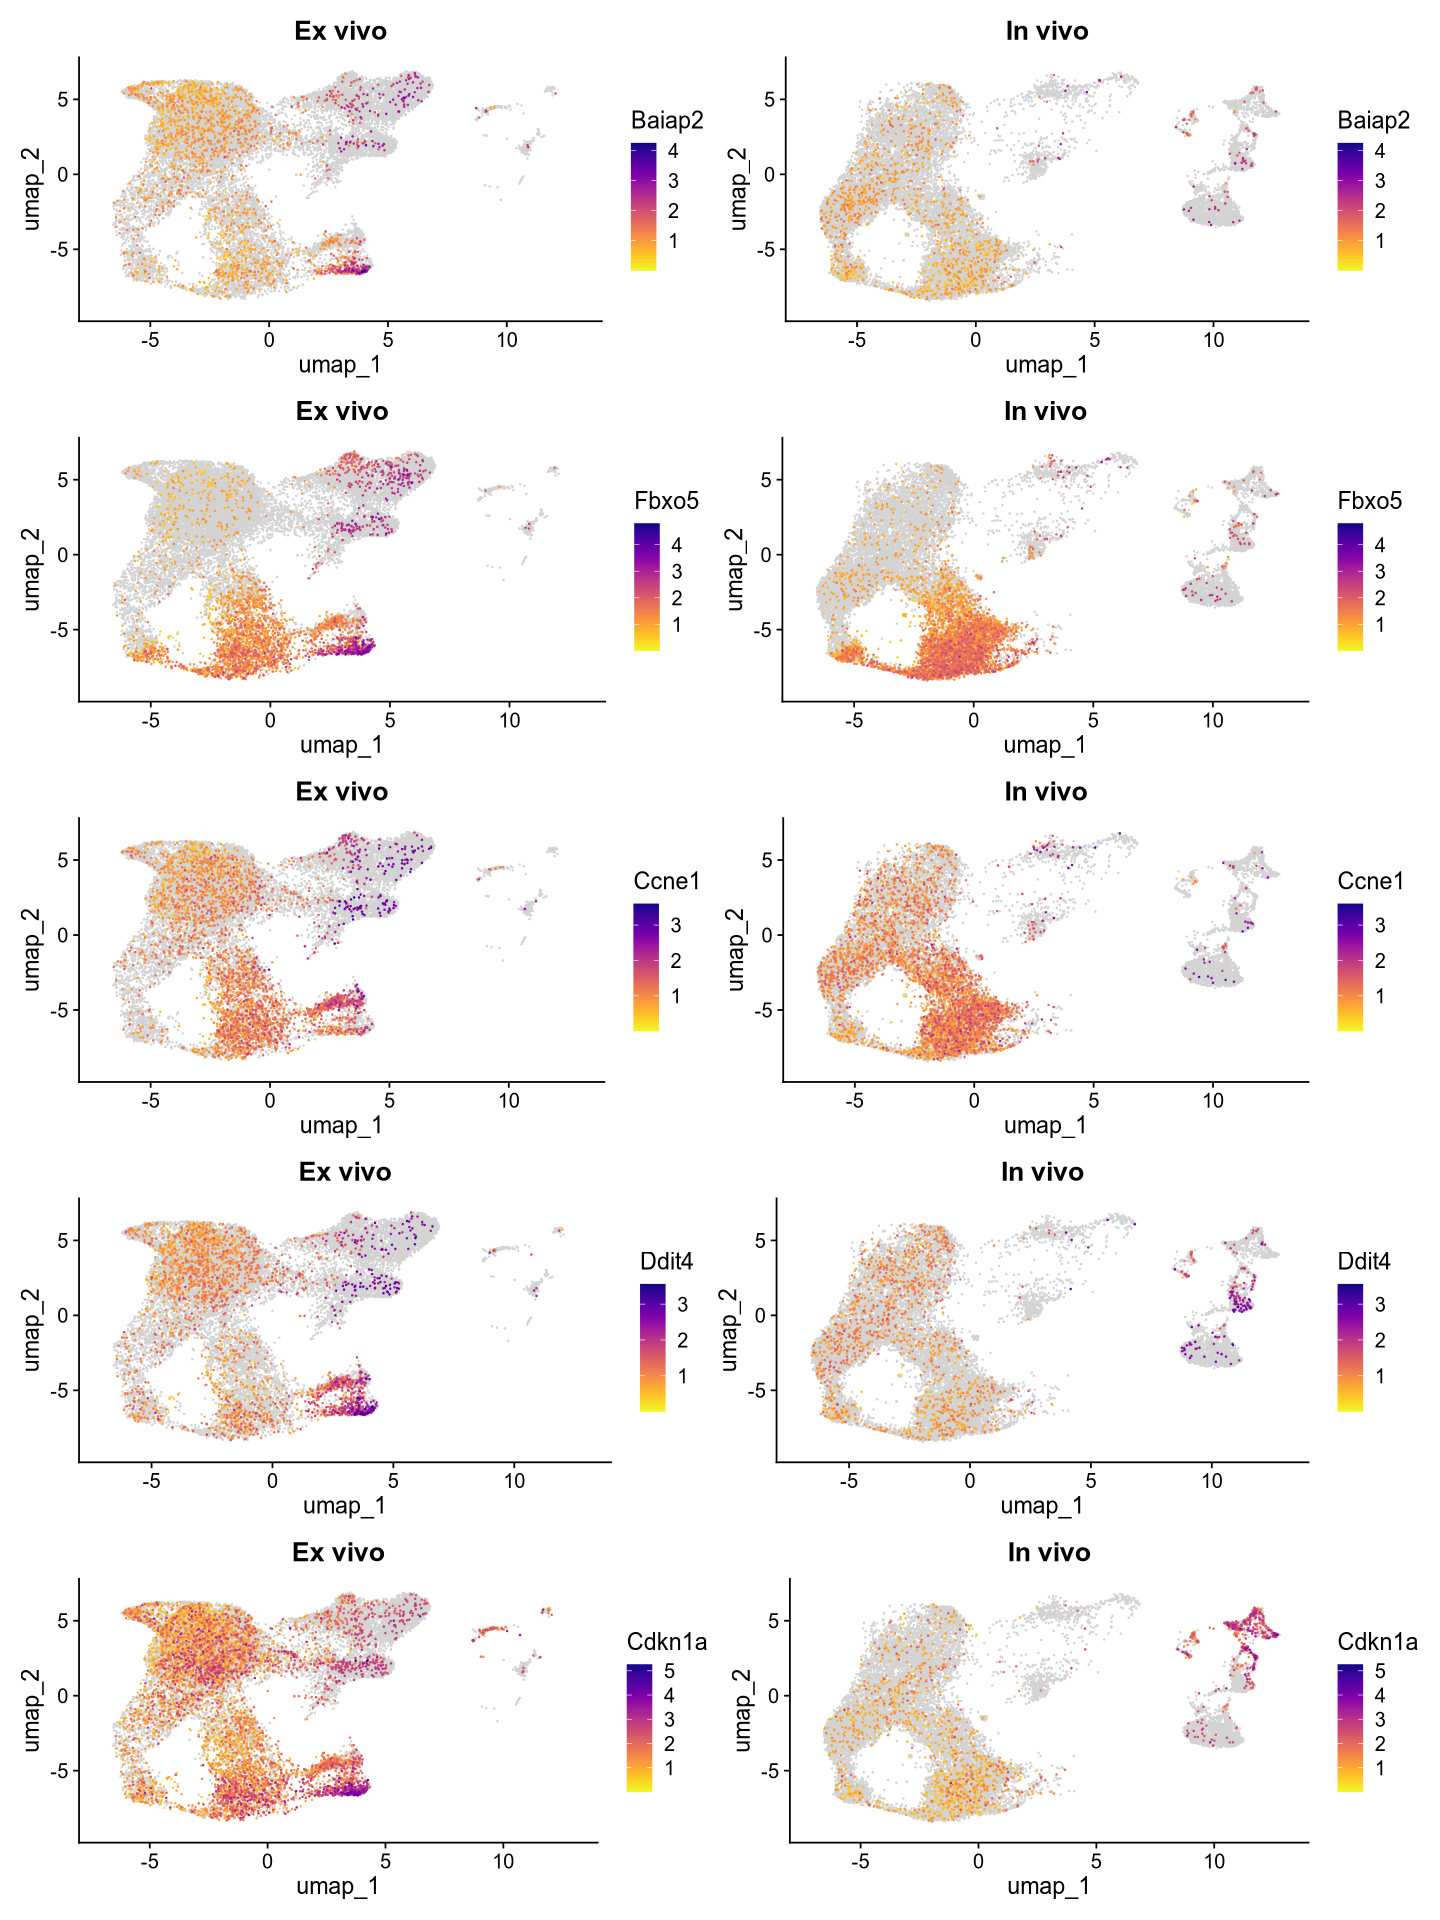

In [40]:
fig.size(16, 12)
plot.list[['S phase Sympathoblasts']]

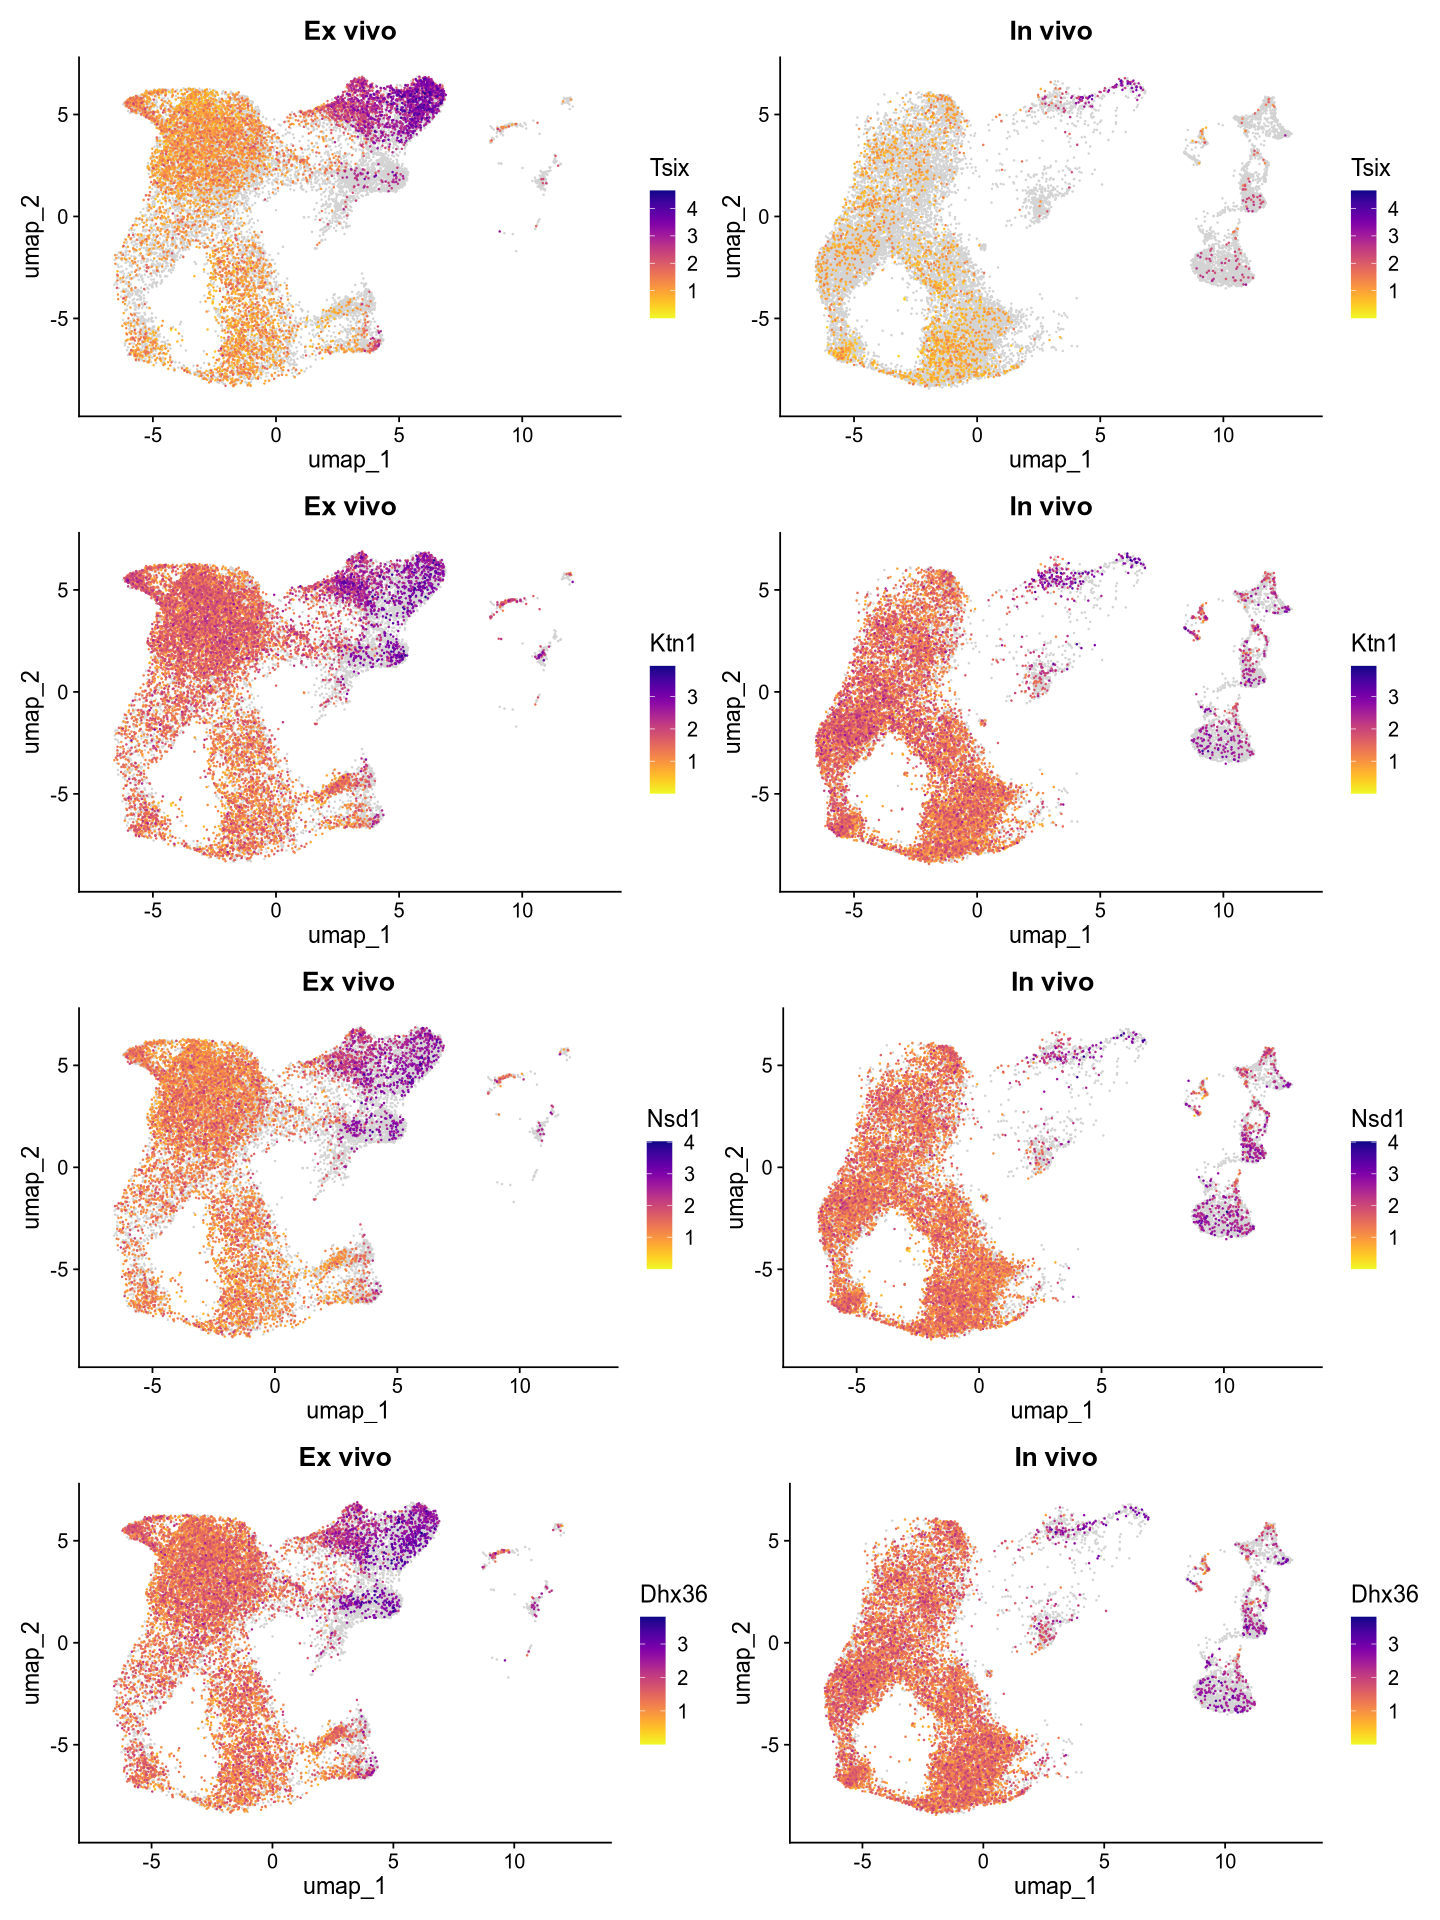

In [41]:
fig.size(16, 12)
plot.list[['Synaptic signaling']]

## Figure 5E

In [47]:
Idents(organoid) = "annot"

In [48]:
Idents(organoid) %>% levels

[1] "G1 phase Sympathoblasts"   "S phase Sympathoblasts"   
 [3] "G2-M phase Sympathoblasts" "Synaptic signaling"       
 [5] "Chromaffin"                "G1-S phase Sympathoblasts"
 [7] "Neurite outgrowth"         "B cells"                  
 [9] "T cells"                   "M phase Sympathoblasts"   
[11] "Myeloid"                   "Neuronal Differentiation" 
[13] "Mesenchymal"

In [49]:
organoid.subset = subset(
    x = organoid,
    idents = signature.df$Annotation %>% unique
)

In [50]:
organoid.subset$annot = factor(organoid.subset$annot, levels = c(
    'Neuronal Differentiation',
    'S phase Sympathoblasts',
    'Neurite outgrowth',
    'Synaptic signaling'
))

Warning message:
“Scaling data with a low number of groups may produce misleading results”


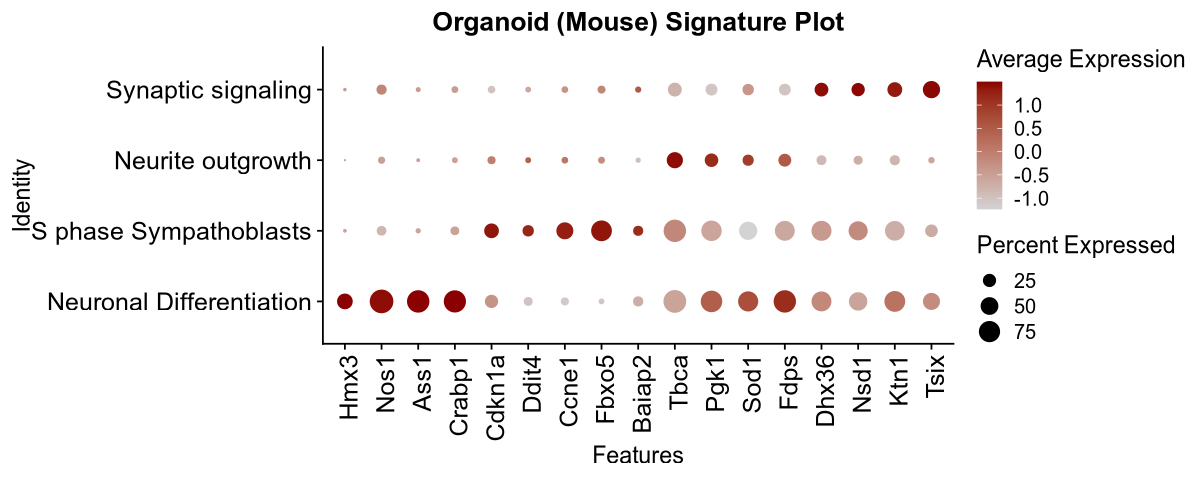

In [51]:
#options(repr.plot.height=15, repr.plot.width=8, res=200)
fig.size(4,10)
#adr.obj.small = adr.obj[dotplot_genes$Gene[2: length(dotplot_genes$Gene)],]
pdot = DotPlot(
       organoid.subset, 
        assay='RNA',
        features = signature.df$Mouse.Gene %>% rev, 
        group.by='annot', 
        scale = TRUE,
        scale.by = 'size',
        cols = c("lightgrey", "darkred")
       )+ ggtitle("Organoid (Mouse) Signature Plot") +
        #coord_flip()+
    theme(
        plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(size=15,angle = 90, hjust = 1,vjust = 0.7),
        axis.text.y = element_text(size=15)
    ) 

pdot

## Figure 5F Survival plots

In [52]:
suppressPackageStartupMessages({
library(dplyr)
library(ggpubr)
library(ggplot2)
library(tidyverse)
library(data.table)
library(biomaRt)
     library(survival)
    library(biomaRt)
    library(survminer)
      library(GEOquery)
    })

In [54]:
gse <- readRDS('survival_data/survival/GSE62564_info.rds')
pdata = pData(gse)
fset = fData(gse)
eset <- exprs(gse)
vals = c('title', "os day:ch1" ,"os bin:ch1", "efs day:ch1", "efs bin:ch1", "age:ch1", "Sex:ch1")
metadata = pdata %>% dplyr::select(vals)
metadata$title <- gsub(" \\[.*\\]", "", metadata$title)
colnames(metadata) = c('title', 'OS.days', 'OS.event', 'EFS.days', 'EFS.event', 'age', 'gender')
expr_gse <- readRDS('survival_data//survival/GSE49710_info.rds')
expr_data = exprs(expr_gse)

risk_metadata = readRDS(
    'survival_data//survival/GSE49710_survival_processed.rds'
)$metadata

fdata_filtered = fData(expr_gse) %>% dplyr::select(c("ID", "GeneSymbol")) %>%
    mutate(`GeneSymbol` = sapply(strsplit(as.character(`GeneSymbol`), " /// "), `[`, 1)) %>%
    filter(!is.na(`GeneSymbol`))
expr_data = expr_data[ fdata_filtered%>% rownames, ]
rownames(expr_data) = fdata_filtered$`GeneSymbol`
survival_data = read.csv('survival_data/survival_data.csv')

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(vals)

  # Now:
  data %>% select(all_of(vals))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [55]:
metadata$time = round(as.numeric(metadata$OS.days)/30,0)
metadata$vital_status = as.numeric(metadata$OS.event)

metadata = merge(metadata, survival_data[,c("Sample.ID", "mycn_status")], by.x = "title", by.y = "Sample.ID")
metadata = merge(metadata,risk_metadata[,c('title', 'risk')],by = 'title')
metadata$mycn_status <- as.numeric(metadata$mycn_status)



Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [56]:
signature.df = openxlsx::read.xlsx(
    'spread_sheets/organoid_survival_signature.xlsx'
)
sig_groups = signature.df %>% 
    group_by(Annotation) %>%
    summarize(ValueList = list(Human.Gene), .groups = 'drop')
sig_groups_list = sig_groups$ValueList
names(sig_groups_list) = sig_groups$Annotation

In [57]:
sig_groups_list

$`Neurite outgrowth`
[1] "FDPS" "SOD1" "PGK1" "TBCA"

$`Neuronal Differentiation`
[1] "CRABP1" "ASS1"   "NOS1"   "HMX3"  

$`S phase Sympathoblasts`
[1] "BAIAP2" "FBXO5"  "CCNE1"  "DDIT4"  "CDKN1A"

$`Synaptic signaling`
[1] "TSIX"  "KTN1"  "NSD1"  "DHX36"

In [64]:
run_surv = function(
    gs,celltype
){
    gs = intersect(gs, rownames(expr_data))
    if(length(gs) == 0){
        return (NULL)
    }
    tmp = expr_data[gs,]
    score = scale(rowMeans(t(tmp)))
    expr_metadata = cbind(data.frame("gene.Z" = score), metadata)
    expr_metadata_mycn = expr_metadata
    #expr_metadata_mycn = na.omit(expr_metadata_mycn)

    ## plot histogram
    percentiles <- quantile(expr_metadata_mycn$gene.Z, probs = c(0.25, 0.75))
    hist(expr_metadata_mycn$gene.Z)
    abline(v = percentiles[1], col = "red", lty = 2)
    abline(v = percentiles[2], col = "red", lty = 2)

    expr_metadata_mycn$exprStatus <- ifelse(expr_metadata_mycn$gene.Z > 0, 1,
                                ifelse(expr_metadata_mycn$gene.Z < 0, 0, 2))

    expr_metadata_mycn <- expr_metadata_mycn[expr_metadata_mycn$exprStatus != 2,]
    expr_metadata_mycn$risk = as.numeric(expr_metadata_mycn$risk)

    # expr_metadata = expr_metadata[!is.na(expr_metadata$mycn_status),]

    fit <- do.call(survfit, list(Surv(eval(parse(text = "time")), eval(parse(text = "risk"))) ~ exprStatus, 
                                 data = expr_metadata_mycn[c("time", "risk", "exprStatus")] ))

    diff <- survdiff(formula = Surv(eval(parse(text="time")), eval(parse(text="risk"))) ~ exprStatus, 
                     data = expr_metadata_mycn[c("time", "risk", "exprStatus")]  )

    pval <- pchisq(diff$chisq, length(diff$n)-1, lower.tail = FALSE)

    adjpval <- p.adjust(pval, method = "fdr",  n = (fit$n[1] + fit$n[2]))

    plotTitle <- paste0(celltype,"-", paste(gs, collapse = " | "), " P-val(Adj) :", 
                        format(pval, scientific=T, digits=3), "(", format(adjpval, scientific=T, digits=3), ")")

    low <- paste0("Low : n = ", fit$n[1])
    high <- paste0("High : n = ", fit$n[2])
    names(fit$strata) <- c(low,high)

    fig.size(8,6)
    plot <- ggsurvplot(fit,
                 data = expr_metadata_mycn,
                 pval = TRUE,
                 pval.size = 5,
                 conf.int = TRUE,
                 risk.table = TRUE, # Add risk table
                 risk.table.col = "strata", # Change risk table color by groups
                 surv.median.line = "hv", # Specify median survival
                 ggtheme = theme_bw(base_size = 14), # Change ggplot2 theme
                 risk.table.fontsize = 5,
                 palette = c("#E7B800", "#2E9FDF"),
                 title = plotTitle) + xlab('Survival Time')
    
    # ggsave(
    #     glue::glue(
    #         '/scratch/gpfs/KANG/hirak/mendel/Projects/neuroblastoma_analysis/',
    #         paste0('results/figures/2024/survival_plot_combined/',celltype,'.pdf')
    #     ),
    #     plot = plot$plot, 
    #     height = 6,
    #     width = 6,
    #     create.dir=TRUE
    # )
    return(plot)
}

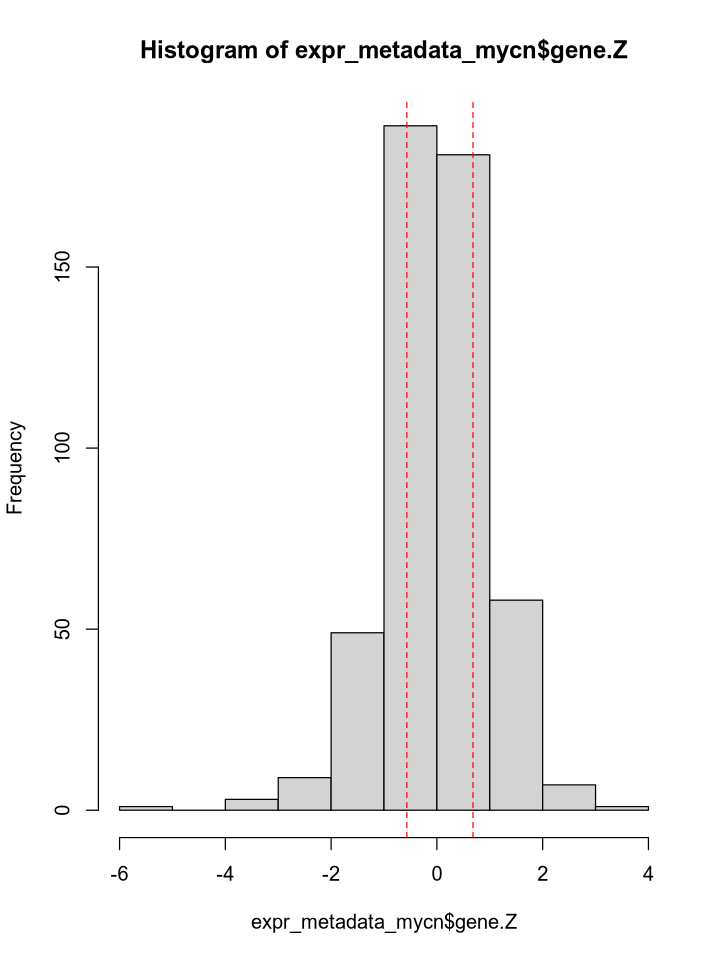

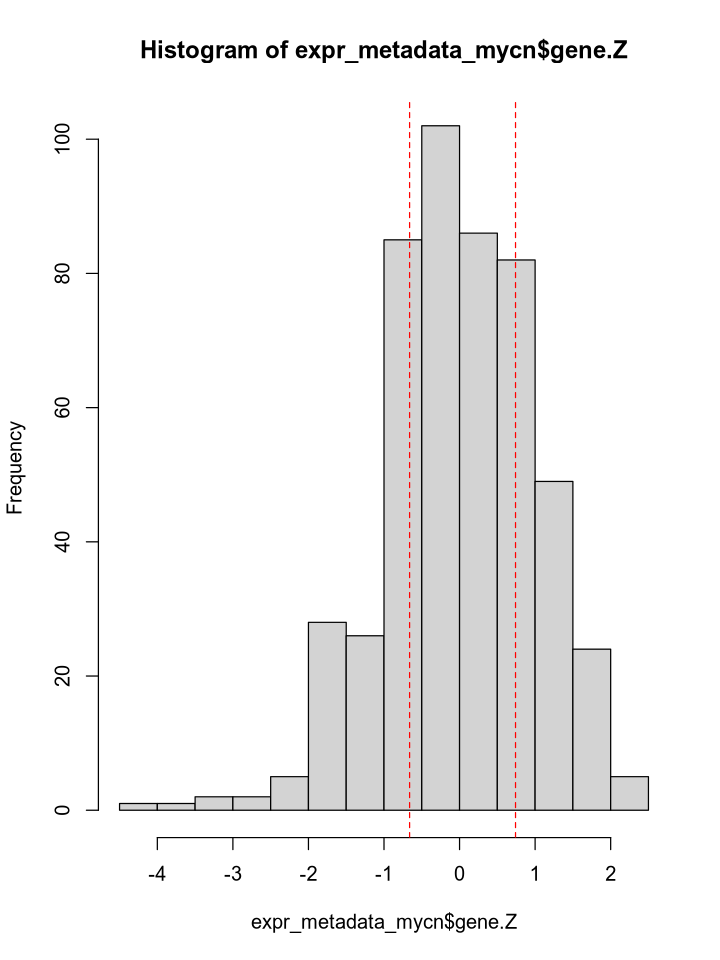

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


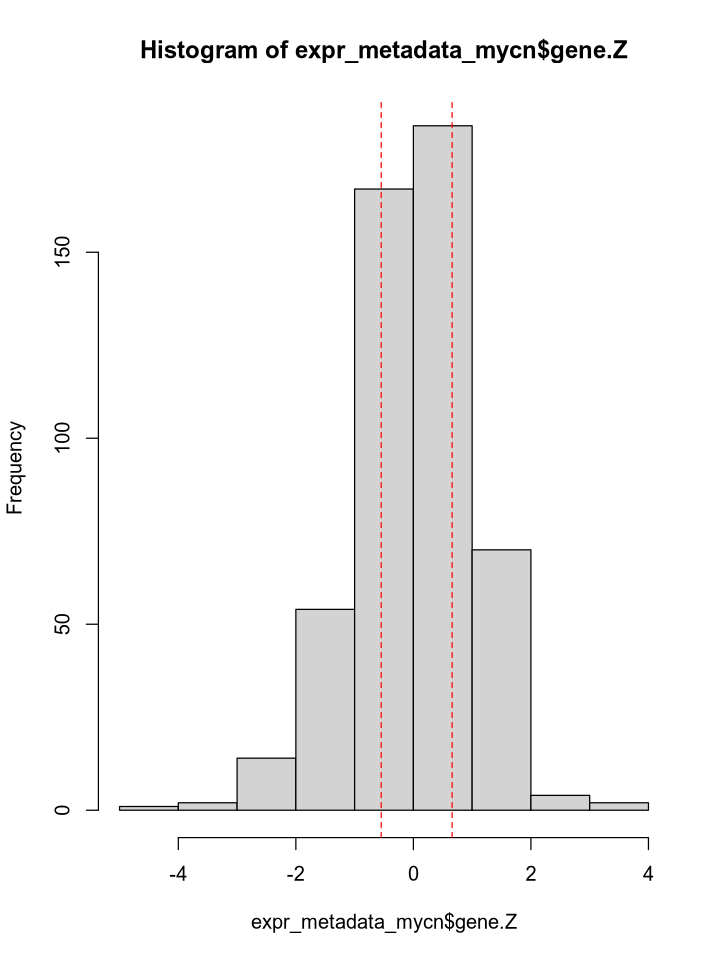

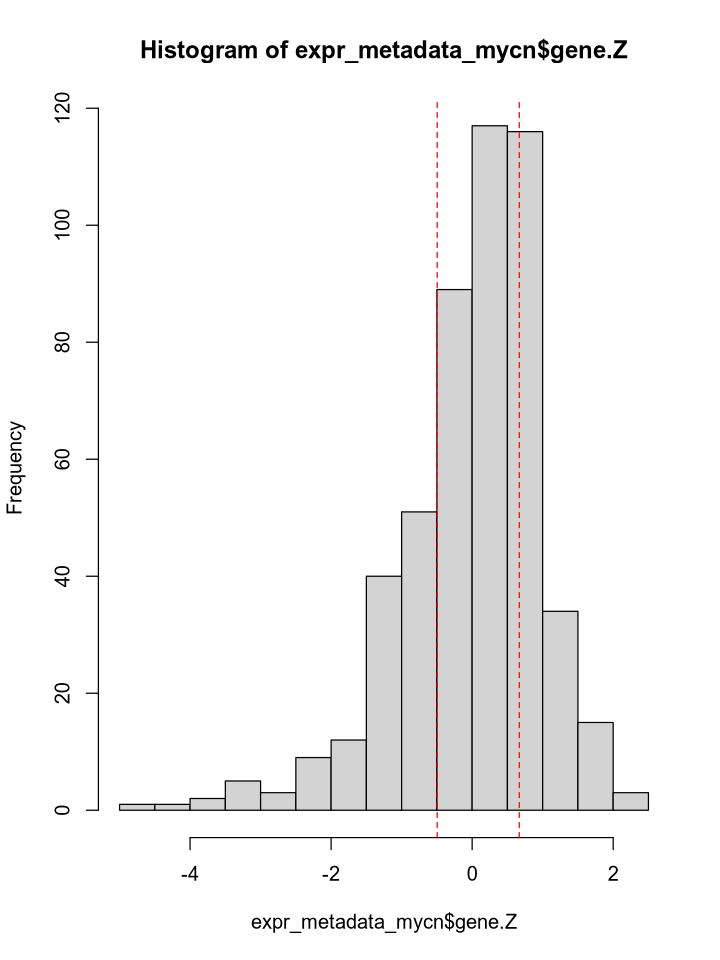

In [65]:
plot.list = list()

for(celltype in names(sig_groups_list)){
    plot.list[[celltype]] = run_surv(sig_groups_list[[celltype]],celltype)
}

In [ ]:
for (cell_type in names(plot.list.mycn)){
    print(plot.list.no.mycn[[cell_type]]$plot)
}

In [66]:
plots <- lapply(names(plot.list), function(cell_type) {
  plot.list[[cell_type]]$plot
})

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Did you mean to use `annotate()`?”


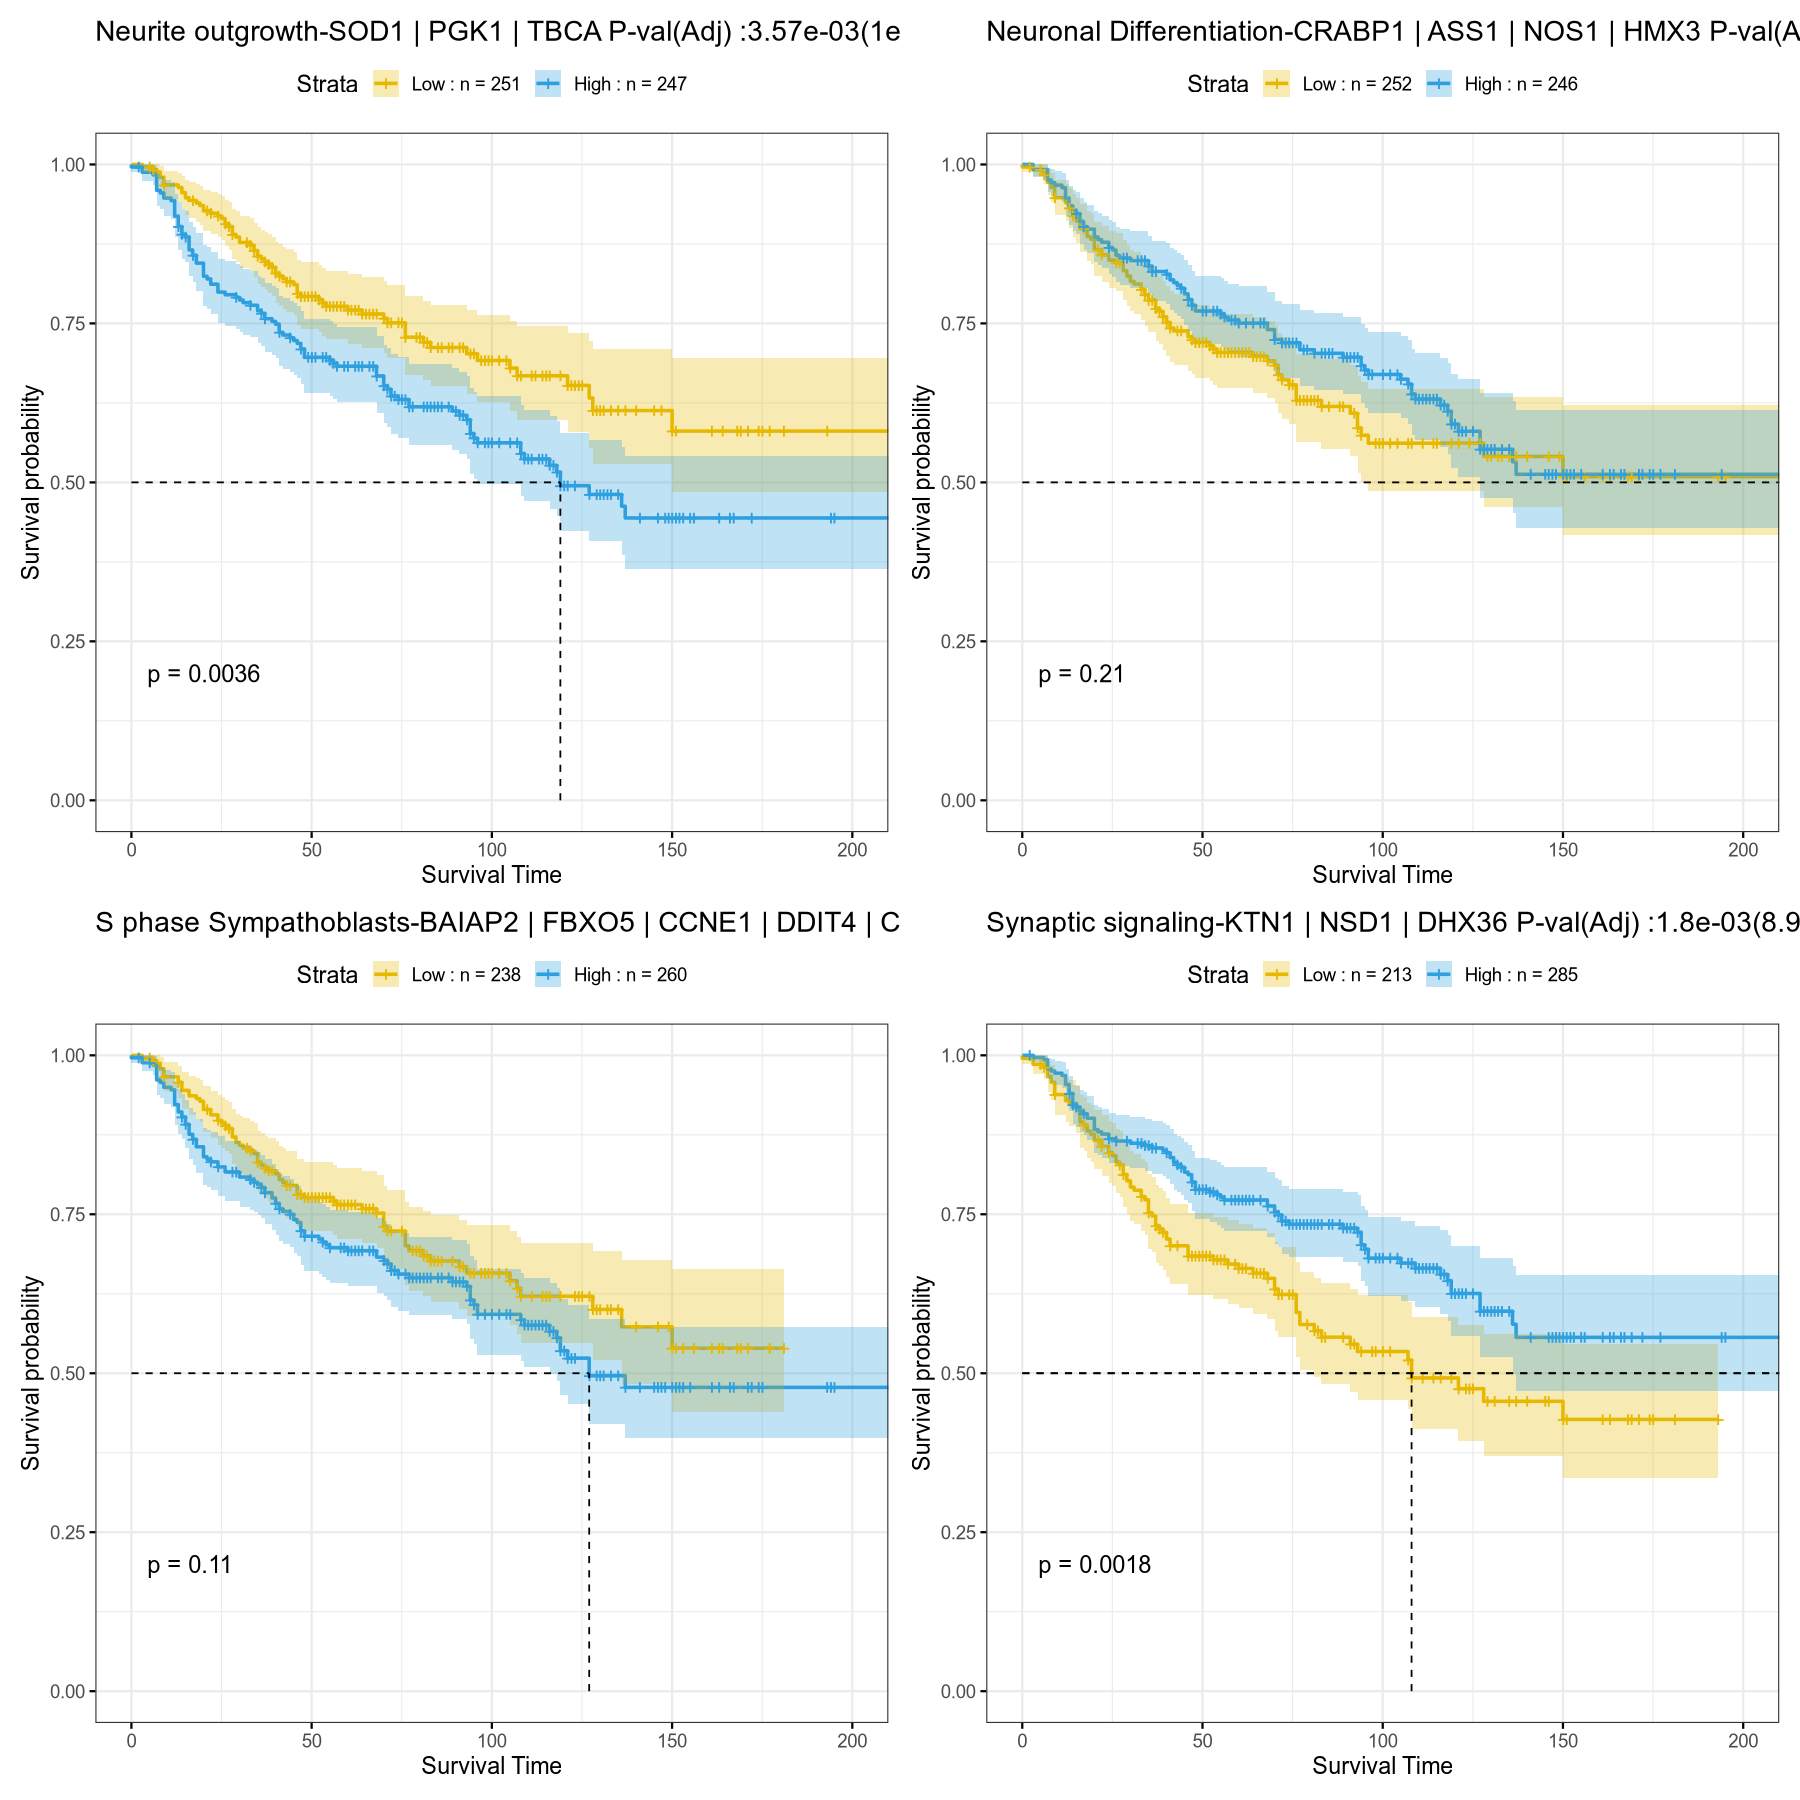

In [68]:
fig.size(15,15)
wrap_plots(plots[1:4], ncol = 2)